In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
!pip install nltk scikit-learn matplotlib scipy

You should consider upgrading via the 'C:\Users\christian\Documents\christian\work\python\cyberspace\topic_modeler\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [12]:
from collections import Counter
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### load dataset

In [5]:
dataset = "newsgroup"

# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

all_docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
all_docs, old_labels, classes = all_docs.data, all_docs.target, all_docs.target_names

In [6]:
# dataset = "bbc"

# data = pd.read_csv('bbcsport.csv')

# all_docs = data["text"].to_list()
# old_labels = data["topic"].to_list()
# categories = classes = np.unique(data["topic"]).tolist()

### clean dataset

In [8]:
datasize = 50
min_document_length = 256
max_document_length = 512


index = -1
docs, labels, label_indices = [], [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        
        if dataset == "bbc":
            size_index = categories.index(old_labels[index])
            
        else:
            size_index = categories.index(classes[old_labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = all_docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if not status:
            continue
            
        if min_document_length is not None and len(doc) < min_document_length:
            continue
            
        if max_document_length is not None and len(doc) > max_document_length:
            continue
        
        label_indices.append(size_index)
        labels.append(categories[size_index])
        docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

labels = np.array(labels)
label_indices = np.array(label_indices)

In [9]:
index = 3
print(f"Topic: {labels[index]}\n{'='*50}\n{docs[index][:512]}")

Topic: sci.space
sorry folk i should have do this and meant to just after i hit the send key orbital element of comet 1977vii from dance file p au 3 424346 e 0 151899 i 1 0988 cap omega 0 243 5652 w 0 231 1607 epoch 1977 04110 also perihelion of gehrels3 be april 1973 83 jupiter radius august 1970 3 jupiter radius hope this help i m even le of an orbital mechanic than i be an artist


In [10]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[50, 50, 50, 50]


## Split data

In [45]:
x_train, x_test, y_train, y_test = train_test_split(docs, labels, test_size =.3)

In [46]:
print(f"there are {len(docs)} total docs, {len(y_train)} train and {len(y_test)} test")

there are 200 total docs, 140 train and 60 test


### Initialize Vectorizer

In [47]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(x_train)

vocabulary = np.array(vectorizer.get_feature_names())
print("word_count is", len(vocabulary))

word_count is 2510


### Prepare Datatset

In [48]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(x_train).toarray()
test_doc_vectors = vectorizer.transform(x_test).toarray()

In [209]:
# reduce freq in doc to bin value of 1 or 0
binary = False

word_freq_in_doc_train = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_freq_in_doc_test = pd.DataFrame(test_doc_vectors, columns=vocabulary)

word_doc_frequency_norm_train = (word_freq_in_doc_train.T / word_freq_in_doc_train.sum(1)).T
word_doc_frequency_norm_test = (word_freq_in_doc_test.T / word_freq_in_doc_test.sum(1)).T

if binary:
    wdf_train = (word_doc_frequency_norm_train > 0).astype(int)
    wdf_test = (word_doc_frequency_norm_test > 0).astype(int)
    
else:    
    wdf_train = word_doc_frequency_norm_train.copy()
    wdf_test = word_doc_frequency_norm_test.copy()

## Word Topic Probability Distr

In [210]:
wdt_train = wdf_train.copy()
wdt_test = wdf_test.copy()

wdt_test["__labels__"] = y_test
wdt_train["__labels__"] = y_train

word_doc_count = wdf_train.sum(0)
topic_doc_count = pd.DataFrame(Counter(y_train), index=[0]).T[0]
word_topic_pr_distr = pd.DataFrame(data=0.0, columns=categories, index=vocabulary)

for category in tqdm(categories):
    pxy = wdf_train[wdt_train["__labels__"] == category].sum(0) / topic_doc_count[category]
    word_topic_pr_distr[category] = pxy * (topic_count[category] / word_doc_count)

print(f"word_topic_pr_distr shape = {word_topic_pr_distr.shape}")


word_topic_pr_distr shape = (2510, 4)


In [211]:
word_topic_pr_distr.head()

,rec.autos,talk.politics.mideast,alt.atheism,sci.space
000,0.0,1.0,0.0,0.0
02,1.0,0.0,0.0,0.0
034101,0.0,0.0,0.0,1.0
04110,0.0,0.0,0.0,1.0
0710,1.0,0.0,0.0,0.0


In [212]:
topic_index = 3
topic = categories[topic_index]

print(f"Topwords: Topic - {topic}\n{'='*50}")
word_topic_pr_distr[topic].sort_values(ascending=False).head(10)

Topwords: Topic - sci.space


sun        1.0
radio      1.0
zillion    1.0
zero       1.0
orbit      1.0
line       1.0
launch     1.0
stick      1.0
eastern    1.0
easily     1.0
Name: sci.space, dtype: float64

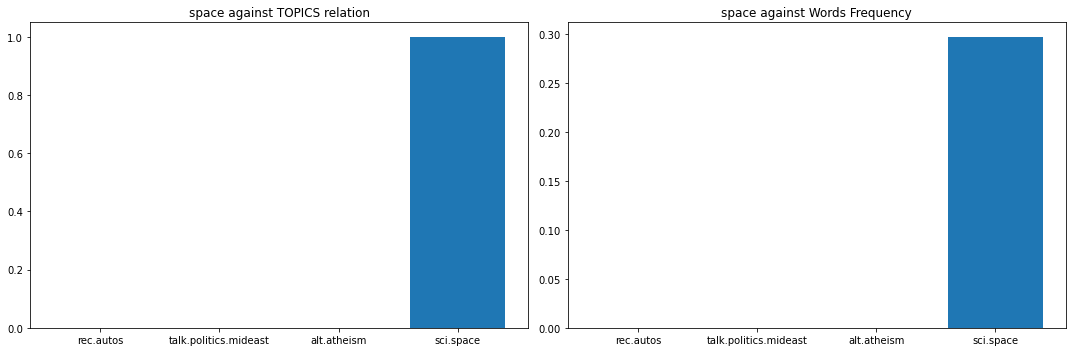

In [213]:
word = "space"

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(121)
ax12 = fig.add_subplot(122)

ax11.set_title(f"{word} against TOPICS relation")
ax11.bar(word_topic_pr_distr.columns, word_topic_pr_distr.loc[word])

word_topic_freq = Counter(wdt_train["__labels__"][wdt_train[word] > 0])
freqs = []
for topic in word_topic_pr_distr.columns:
#     freqs.append(word_topic_freq[topic])
    freqs.append(word_topic_freq[topic] / topic_count[topic])

ax12.set_title(f"{word} against Words Frequency")
ax12.bar(word_topic_pr_distr.columns, freqs)

plt.show()

### Quick Topic Inference

Document: 0, Topic: rec.autos
sometimes a bad choke pull off diaphram will cause a car to fast idle the pull off which be vacuum actuate provide a necessary pull in non cold weather condition to get the idle off the the fast idle cam locate the fast idle cam on your vehicle and see if you can rotate it to produce a normal idle if so locate the diaphram and test it if you can t apply suction via a good piece of rubber vacuum hose with your mouth that will cause the diaphram to retract then it s bad and should be replace

Inference: Document 0
actual = rec.autos, predicted = rec.autos

Topwords: Document 0
the         0.075269
idle        0.053763
to          0.043011
it          0.032258
fast        0.032258
and         0.032258
diaphram    0.032258
off         0.032258
Name: 0, dtype: float64


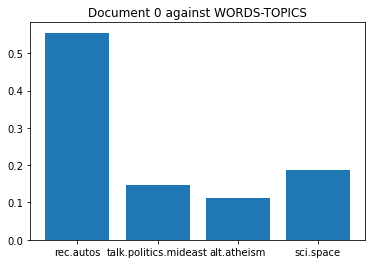

In [214]:
doc_index = 0
num_of_topwords = 8

doc_index = 0
print(f"Document: {doc_index}, Topic: {y_train[doc_index]}\n{'='*50}\n{x_train[doc_index][:512]}\n")

doc_vector = wdf_train.loc[doc_index]
doc_word_topic_pr_distr, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)

print(f"Inference: Document {doc_index}\n{'='*50}")
print(f"actual = {wdt_train.loc[doc_index]['__labels__']}, predicted = {predicted_doc_topic}\n")

print(f"Topwords: Document {doc_index}\n{'='*50}")
print(wdf_train.loc[doc_index].sort_values(ascending=False).head(num_of_topwords))

plt.title(f"Document {doc_index} against WORDS-TOPICS")
plt.bar(categories, doc_word_topic_pr_distr.sum(0))
plt.show()

## Topic Word Distr - Train Accuracy

In [215]:
score_train = 0
for doc_index in tqdm(range(len(y_train))):
    doc_vector = wdf_train.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)
    
    mark = wdt_train.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_train += mark

train_accuracy = score_train * 100 / len(y_train)
print(f"accuracy = {train_accuracy: .2f}%")


accuracy =  92.14%


## Topic Word Distr - Test Accuracy

In [216]:
score_test = 0
for doc_index in tqdm(range(len(y_test))):
    doc_vector = wdf_test.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)
    
    mark = wdt_test.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_test += mark

test_accuracy = score_test * 100 / len(y_test)
print(f"test accuracy = {test_accuracy: .2f}%")


test accuracy =  45.00%


### Word Word Probability Distr

In [223]:
word_word_pr_distr = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

for word in tqdm(vocabulary):
    pxy = wdf_train[wdf_train[word] > 0].sum(0) / word_doc_count[word]
#     pxy = (wdf_train.T * wdf_train[word]).sum(1)/ word_doc_count[word]
    word_word_pr_distr.loc[word] = pxy * (word_doc_count[word] / word_doc_count)

print(f"word_word_pr_distr shape = {word_word_pr_distr.shape}")


word_word_pr_distr shape = (2510, 2510)


In [224]:
word_word_pr_distr.head()

,000,02,034101,04110,0710,0988,10,11,124mph,15,...,yuma,yurrruuu,yuru,zealand,zeitgeist,zero,zillion,zip,zone,zu
000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
034101,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
04110,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0710,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [228]:
word = "sun"

print(f"Topwords: Word - {word}\n{'='*50}")
word_word_pr_distr.loc[word].sort_values(ascending=False).head(10)

Topwords: Word - sun


input       1.0
public      1.0
extract     1.0
skeptic     1.0
msdos       1.0
domain      1.0
marxism     1.0
bay         1.0
sunlight    1.0
netcom      1.0
Name: sun, dtype: float64

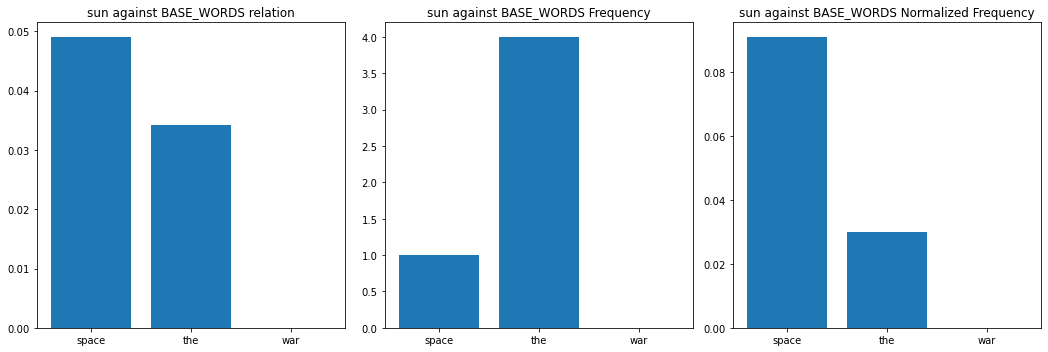

In [230]:
word = "sun"
base_words = ["space", "the", "war"]

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(131)
ax12 = fig.add_subplot(132)
ax13 = fig.add_subplot(133)

ax11.set_title(f"{word} against BASE_WORDS relation")
ax11.bar(base_words, word_word_pr_distr.loc[word][base_words])

freqs, norm_freqs = [], []
wdc = (wdt_train[base_words] > 0).sum(0)
word_word_freq = (wdt_train[base_words][wdt_train[word] > 0] > 0).sum(0)

for w in base_words:
    freqs.append(word_word_freq[w])
    norm_freqs.append(word_word_freq[w] / wdc[w])

ax12.set_title(f"{word} against BASE_WORDS Frequency")
ax12.bar(base_words, freqs)

ax13.set_title(f"{word} against BASE_WORDS Normalized Frequency")
ax13.bar(base_words, norm_freqs)

plt.show()

## Word distr 2

In [231]:
word_word_pr_distr2 = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

for word in tqdm(vocabulary):
    pxy = (wdf_train.T * wdf_train[word]).sum(1)/ word_doc_count[word]
    word_word_pr_distr2.loc[word] = pxy * (word_doc_count[word] / word_doc_count)

print(f"word_word_pr_distr shape = {word_word_pr_distr.shape}")


word_word_pr_distr shape = (2510, 2510)


In [232]:
word = "sun"

print(f"Topwords: Word - {word}\n{'='*50}")
word_word_pr_distr2.loc[word].sort_values(ascending=False).head(10)

Topwords: Word - space


francisco     0.039474
4368          0.039474
forgotten     0.039474
kept          0.039474
awful         0.039474
crumb         0.039474
ken           0.039474
crumbly       0.039474
gothamcity    0.039474
483           0.039474
Name: space, dtype: float64

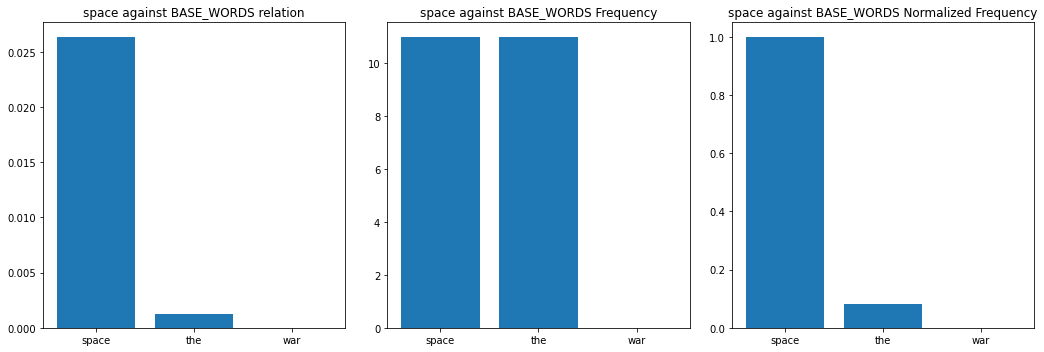

In [233]:
word = "sun"
base_words = ["space", "the", "war"]

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(131)
ax12 = fig.add_subplot(132)
ax13 = fig.add_subplot(133)

ax11.set_title(f"{word} against BASE_WORDS relation")
ax11.bar(base_words, word_word_pr_distr2.loc[word][base_words])

freqs, norm_freqs = [], []
wdc = (wdt_train[base_words] > 0).sum(0)
word_word_freq = (wdt_train[base_words][wdt_train[word] > 0] > 0).sum(0)

for w in base_words:
    freqs.append(word_word_freq[w])
    norm_freqs.append(word_word_freq[w] / wdc[w])

ax12.set_title(f"{word} against BASE_WORDS Frequency")
ax12.bar(base_words, freqs)

ax13.set_title(f"{word} against BASE_WORDS Normalized Frequency")
ax13.bar(base_words, norm_freqs)

plt.show()